In [137]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
from scipy.signal import hilbert
import numpy as np
from sklearn.decomposition import PCA

In [121]:
fruit_types = ['pera', 'banana', 'manzana', 'naranja']
fruits = {fruit: [] for fruit in fruit_types}
root_dir = '../../dataset'

for dirname, _, filenames in os.walk(root_dir):
    fruit_type = os.path.basename(dirname)
    if fruit_type in fruit_types:
        fruits[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [122]:
trimed_audio = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(root_dir):
    trimpath = os.path.basename(dirname)

    if trimpath in 'trimed':
        fruit_type = os.path.basename(os.path.dirname(dirname))
        if fruit_type in fruit_types:
            trimed_audio[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [123]:
adjusted_audio = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(root_dir):
    adjustedpath = os.path.basename(dirname)

    if adjustedpath in 'adjusted':
        fruit_type = os.path.basename(os.path.dirname(dirname))
        if fruit_type in fruit_types:
            adjusted_audio[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [124]:
FRAME_SIZE = 512 # In the documentation says it's convenient for speech.C
HOP_SIZE   = 256

In [146]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [126]:
def get_features(n_mfcc, fruits):
    fruit_vectors = dict.fromkeys(fruits.keys())
    
    for fruit_name, group in fruits.items():
        vectors = list()
        for fruit in group:
            signal, sr, _ = load_audio(fruit)
            mfccs = librosa.feature.mfcc(y=signal, n_mfcc=n_mfcc, sr=sr)
            delta_mfccs = librosa.feature.delta(mfccs)
            delta2_mfccs = librosa.feature.delta(mfccs, order = 2)
            
            # Paso 1: Calcular la envolvente utilizando la transformada de Hilbert
            analytic_signal = hilbert(signal)
            amplitude_envelope = np.abs(analytic_signal)

            # Paso 2: Evaluar la envolvente en n puntos equiespaciados
            n_points = n_mfcc  # Número de puntos a evaluar
            evaluated_points = np.linspace(0, len(amplitude_envelope), n_points, endpoint=False, dtype=int)
            envolvente_evaluada = amplitude_envelope[evaluated_points]
            envolvente_evaluada = envolvente_evaluada.reshape(-1, 1)
            features =  np.concatenate((mfccs, delta_mfccs, delta2_mfccs, envolvente_evaluada), axis = 1)
            features = np.mean(features.T, axis = 0)
            vectors.append(features.reshape(1,-1))
        fruit_vectors[fruit_name] = np.vstack(vectors)
    return fruit_vectors

lo siguente constituye una prueba del cálculo de las envolventes

In [ ]:
# Supongamos que tienes la señal de audio en un array llamado 'audio_signal' y la frecuencia de muestreo en 'sample_rate'
fruit = 'pera'
indice = 6


# Función para cargar la señal de audio y calcular la envolvente
def calculate_amplitude_envelope(file_path):
    # Cargar la señal de audio
    signal, sr = librosa.load(file_path, sr=None)

    # Calcular la transformada de Hilbert
    analytic_signal = hilbert(signal)

    # Calcular la envolvente de amplitud
    amplitude_envelope = np.abs(analytic_signal)

    return signal, sr, amplitude_envelope

# Ruta de tu archivo de audio
file_path = fruits[fruit][indice]

# Calcular la señal y la envolvente de amplitud
original_signal, sr, amplitude_envelope = calculate_amplitude_envelope(file_path)

# Crear el gráfico
plt.figure(figsize=(12, 6))

# Visualizar la señal original
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(original_signal)) / sr, original_signal)
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

# Visualizar la envolvente de amplitud
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(amplitude_envelope)) / sr, amplitude_envelope, alpha=0.5)
plt.title('Envolvente de Amplitud')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

# Ajustar el diseño del gráfico
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt

fruit = 'pera'
indice = 6

# Función para cargar la señal de audio y calcular la envolvente suavizada
def calculate_smoothed_envelope(file_path, cutoff_frequency=10.0):
    # Cargar la señal de audio
    signal, sr = librosa.load(file_path, sr=None)

    # Calcular la transformada de Hilbert
    analytic_signal = hilbert(signal)

    # Calcular la envolvente de amplitud
    amplitude_envelope = np.abs(analytic_signal)

    # Aplicar filtro pasa bajos para suavizar la envolvente
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    print(f"(b, a): ({b},{a})")
    smoothed_envelope = filtfilt(b, a, amplitude_envelope)

    return signal, sr, amplitude_envelope, smoothed_envelope

# Ruta de tu archivo de audio
file_path = fruits[fruit][indice]

# Calcular la señal y las envolventes
original_signal, sr, amplitude_envelope, smoothed_envelope = calculate_smoothed_envelope(file_path, 50)

# Crear el gráfico
plt.figure(figsize=(12, 8))

# Visualizar la señal original
plt.subplot(3, 1, 1)
plt.plot(np.arange(len(original_signal)) / sr, original_signal)
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

# Visualizar la envolvente de amplitud
plt.subplot(3, 1, 2)
plt.plot(np.arange(len(amplitude_envelope)) / sr, amplitude_envelope, alpha=0.5, label='Envolvente Original')
plt.title('Envolvente de Amplitud Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

# Visualizar la envolvente suavizada
plt.subplot(3, 1, 3)
plt.plot(np.arange(len(smoothed_envelope)) / sr, smoothed_envelope, label='Envolvente Suavizada', color='orange')
plt.title('Envolvente de Amplitud Suavizada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

# Ajustar el diseño del gráfico
plt.tight_layout()
plt.show()


In [171]:
#-------------------------------------------------------------------------------------#

2.5

In [127]:
def get_sphere(vectors):
    center = np.mean(vectors, axis = 0)
    center = center.reshape(1, -1)
    radius = cdist(center, vectors).max()     # Pairwise distance
    return radius, center

In [128]:
def get_centers(features):
    centers = dict.fromkeys(features.keys())
    for fruit, group in features.items():
        _, center = get_sphere(group)
        centers[fruit] = center
    return centers

In [129]:
def get_radiuses(features):
    radiuses = dict.fromkeys(features.keys())
    for fruit, group in features.items():
        radius, _ = get_sphere(group)
        radiuses[fruit] = radius
    return radiuses

In [130]:
def get_overlaps(fruit_features):
    centers = get_centers(fruit_features)
    radiuses = get_radiuses(fruit_features)
    overlaps = dict.fromkeys(fruit_features.keys())
    
    # A dictionary of dictionarys. Keys, the fruit types
    for key in overlaps:
        # Each dictionary in the dictionary
        overlaps[key] = dict.fromkeys(fruit_types)
    
    for i in range(len(fruit_types)):
        for j in range(i + 1, len(fruit_types)):
            distancesAB = cdist(centers[fruit_types[i]], fruit_features[fruit_types[j]])
            distancesBA = cdist(centers[fruit_types[j]], fruit_features[fruit_types[i]])

            mask_distancesAB = distancesAB < radiuses[fruit_types[i]]
            mask_distancesBA = distancesBA < radiuses[fruit_types[j]]

            numberBinA = np.count_nonzero(mask_distancesAB)
            numberAinB = np.count_nonzero(mask_distancesBA)

            overlaps[fruit_types[i]][fruit_types[j]] = numberBinA
            overlaps[fruit_types[j]][fruit_types[i]] = numberAinB
    return overlaps # Each element is the number of vectors of one group in the sphere of another

In [131]:
def get_components(centers, nc):
    pacum = np.zeros((1, centers[fruit_types[0]].shape[1]))
    pair_components = dict()
    for i in range(len(fruit_types)):
        for j in range(i + 1, len(fruit_types)):
            dif = centers[fruit_types[i]] - centers[fruit_types[j]]
            dist = cdist(centers[fruit_types[i]], centers[fruit_types[j]])
            difp = (dif**2)*100/(dist**2)
            pair_components[f"{fruit_types[i]}-{fruit_types[j]}"]= np.argsort(difp[0])[-nc:]
            pacum += difp
    index_max = np.argsort(pacum[0])[-nc:]
    #return np.sort(index_max)
    return index_max, pair_components

In [132]:
features = get_features(13, trimed_audio)
overlaps = get_overlaps(features)
centers = get_centers(features)
components, _ = get_components(centers, 2) 
radius, _ = get_sphere(np.squeeze(list(centers.values()), axis=1))

print(f"componentes: {components}")

for pair, overlap in overlaps.items():
    print(f"{pair}: {overlap}")

print(f"radius: {radius}")
for name, group in features.items():
    features[name] = group[:, np.sort(components)]
#whole = np.concatenate(list(features.values()), axis=0)

# Paso 2: Aplicar PCA para obtener dos componentes principales
#pca = PCA(n_components = 2)
#reduced_features = pca.fit_transform(whole)

# Paso 3: Crear un diccionario con las matrices reducidas
#reduced = {}
#start_idx = 0

#for fruit, matrix in features.items():
#    num_rows = matrix.shape[0]
#    reduced[fruit] = reduced_features[start_idx:start_idx + num_rows, :]
#    start_idx += num_rows
#features = reduced

C:\Users\Juan\AppData\Local\Temp\ipykernel_10956\3615250506.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile)


componentes: [0 4]
pera: {'pera': None, 'banana': 8, 'manzana': 6, 'naranja': 8}
banana: {'pera': 6, 'banana': None, 'manzana': 8, 'naranja': 9}
manzana: {'pera': 6, 'banana': 8, 'manzana': None, 'naranja': 8}
naranja: {'pera': 10, 'banana': 10, 'manzana': 10, 'naranja': None}
radius: 11.05493718071288


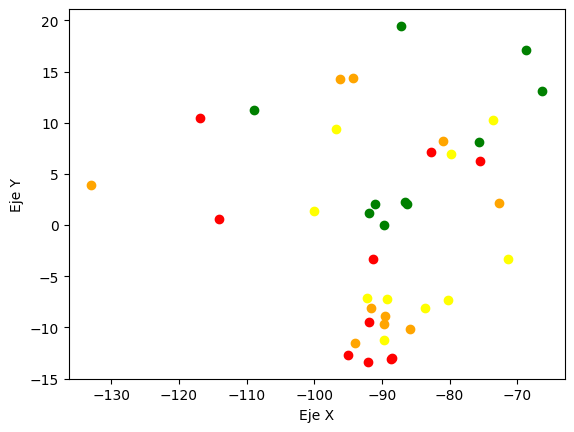

In [133]:
fig = plt.figure()

colors = dict(zip(fruit_types,['green','yellow','red','orange']))
center_colors  = dict(zip(fruit_types,['blue','brown','black','cyan']))

for fruit, points in features.items():
    plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

plt.xlabel('Eje X')
plt.ylabel('Eje Y')

plt.show()